In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
words[:8]
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [9]:
C = torch.randn((27, 2))

In [10]:
C[5]

tensor([0.7838, 0.1632])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.7838, 0.1632])

one hot encoding is equivalent to indexing

In [12]:
# can also index with multi dimensional tensors
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [20]:
# equivalent ways to concat
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
torch.cat(torch.unbind(emb, 1), 1)

# more efficient: .view
emb.view(-1, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # check broadcasting rules when adding
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [18]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([228146, 27])

In [21]:
loss = -probs[-1, Y].log().mean()
loss

tensor(18.5091)

In [22]:
# clean version of above
g = torch.Generator().manual_seed(0) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [23]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [24]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # equivalent to 3 prev lines
loss

tensor(15.2503, grad_fn=<NllLossBackward0>)

In [25]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [26]:
# lri = []
# lossi = []

for i in range(10000):  
  # minibatch
  idxs = torch.randint(0, X.shape[0], (32,))
  
  # fwd pass
  emb = C[X[idxs]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[idxs]) # equivalent to 3 prev lines
  # print(loss.item())

  # bwd pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 10**-2
  for p in parameters:
    p.data += -lr * p.grad
    
  # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())
  
print(loss.item())


2.5712389945983887


In [27]:
plt.plot(lri, lossi) 
# for determining learning rate
# choose a rate in the valley

NameError: name 'lri' is not defined

In [28]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.6111984252929688

## splits: training, dev, test

In [5]:
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [6]:
emb_dim = 5

g = torch.Generator().manual_seed(0) # for reproducibility
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((block_size*emb_dim, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters) # number of parameters in total

14562

In [9]:
stepi = []
lossi = []

In [10]:
lr_opt = torch.optim.SGD(parameters, lr=0.1)  # Initialize optimizer
scheduler = torch.optim.lr_scheduler.StepLR(lr_opt, step_size=20000, gamma=0.75)

for i in range(200000):  
  # minibatch
  idxs = torch.randint(0, Xtr.shape[0], (32,))
  
  # fwd pass
  emb = C[Xtr[idxs]]
  h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[idxs]) # equivalent to 3 prev lines

  # bwd pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lr_opt.param_groups[0]['lr']
  for p in parameters:
    p.data += -lr * p.grad
  
  # step lr
  lr_opt.step()
  scheduler.step()
  
  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
  
  if i % 20000 == 0:
    print(i, lr)
  
print(loss.item())


0 0.1
20000 0.07500000000000001
40000 0.05625000000000001
60000 0.0421875
80000 0.031640625000000006
100000 0.023730468750000004
120000 0.0177978515625
140000 0.013348388671875001
160000 0.01001129150390625
180000 0.007508468627929688
2.3757710456848145


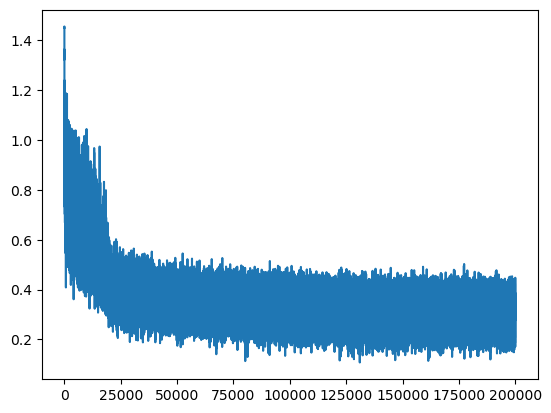

In [11]:
plt.plot(stepi, lossi)

In [12]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1183133125305176

In [13]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0741024017333984

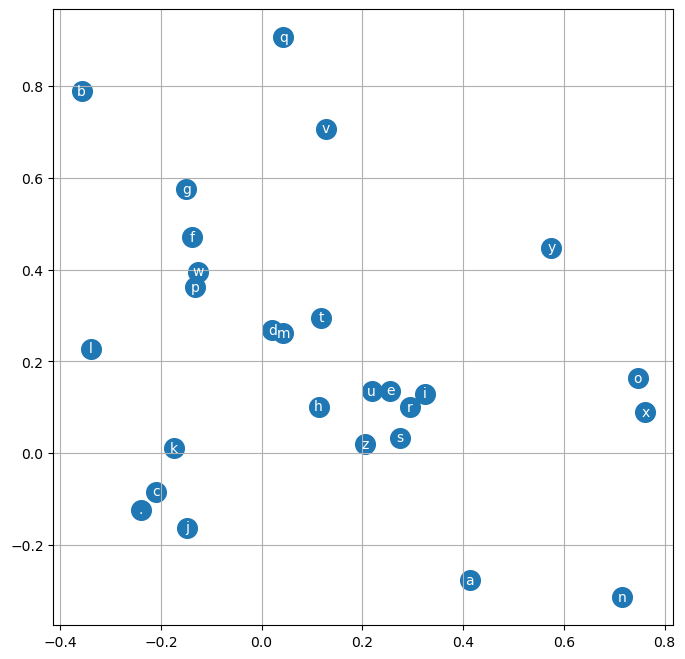

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### how it works

context size: 3 \
name: braeden

context -> output
- bra -> e
- rae -> d
- aed -> e \
...

## sampling

In [1]:
# sample from the model
g = torch.Generator().manual_seed(7)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]))

NameError: name 'torch' is not defined

# Exercises

### E01

i suspect block size should be abt half the length of the avg name. shorter its hard to get structure of names. longer and the model spends a lot of time reading the `.` char

In [ ]:
torch.tensor([len(word) for word in words]).float().mean()

tensor(6.1222)

3 or 4 seems to be a good value for blocksize

In [ ]:
import math
math.sqrt(27)

5.196152422706632

#### achieved loss of 2.136!

tried:
- lowering embedding dimensions to approx sqrt of char space
- increasing blocksize for more context
- more advanced updating of loss rate
- arbitrarily increasing size of hidden layer

observations:
- increasing embedding dims past a certain limit exponentially impacts training time (limit depends on other hyper params like blocksize)
- increasing batch size exponentially increases training time
- currently model trains in abt 90 seconds

things to try:
- tune loss rate more. seems to be most impactful
- find a way to increase batch size and wait to train, if improves loss significantly might be worth extra training time

In [ ]:
# time to test!! :)
emb = C[Xte]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()

2.117854118347168

2.117 test loss!!!

that seems pretty good to me. model is not drastically overfitting data :)